In [ ]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import stLVG_upload
from stLVG_upload.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from stLVG_upload.viz import match_3D_multi, hist, Sankey, build_3D
from stLVG_upload.metrics import region_statistics

In [2]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\Result\BRCA_SLAT_S2_2.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region_real', 'tumor_region', 'leiden_slat'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Spatial_Net', 'spatial', 'tumor_region_colors', 'tumor_region_real_colors'
    obsm: 'scSLAT', 'spatial'

In [3]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\Result\BRCA_SLAT_S1_2.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'leiden_slat'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cell_type_colors', 'Spatial_Net', 'spatial'
    obsm: 'scSLAT', 'spatial'

In [6]:
csv_data = pd.read_csv("D:\ppppaper\data\BrCa\BAS2_anno_2.csv", index_col=0)
adata_1.obs = adata_1.obs.join(csv_data)

In [7]:
csv_data_2 = pd.read_csv("D:\ppppaper\data\BrCa\BAS1_anno_2.csv", index_col=0)
adata_2.obs = adata_2.obs.join(csv_data_2)

In [8]:
spot_size = 200
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

In [49]:
adata_1

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region_real', 'tumor_region', 'leiden_slat', 'anno_2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Spatial_Net', 'spatial', 'tumor_region_colors', 'tumor_region_real_colors'
    obsm: 'scSLAT', 'spatial'

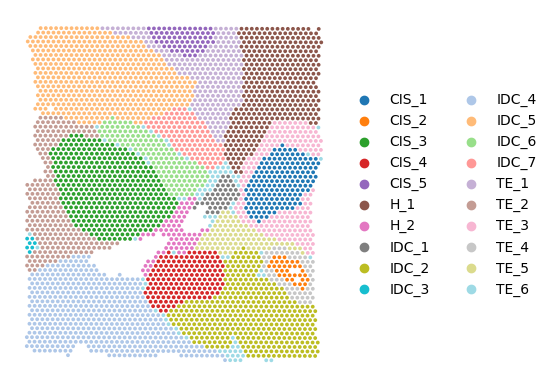

In [50]:
sc.pl.spatial(adata_1, img_key=None, color=['anno_2'], title=[''],
                show=True, frameon=False, palette = pathology_color,
                spot_size=spot_size)

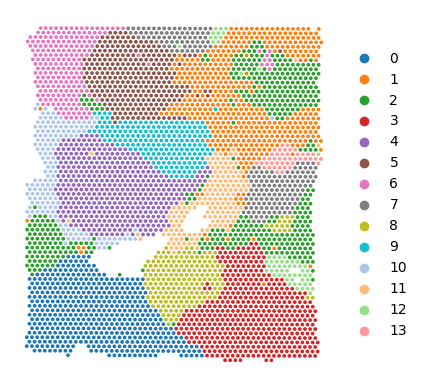

In [51]:
sc.pl.spatial(adata_1, img_key=None, color=['leiden_slat'], title=[''],
                show=True, frameon=False, palette = pathology_color,
                spot_size=spot_size)

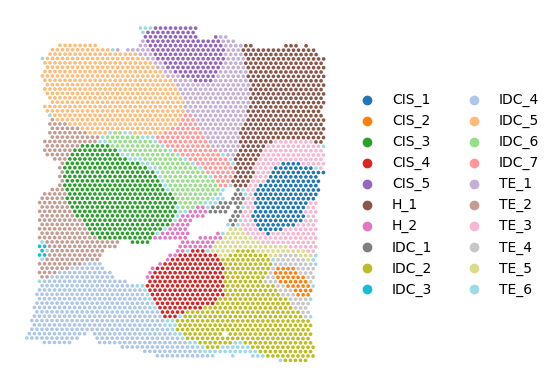

In [52]:
sc.pl.spatial(adata_2, img_key=None, color=['anno_2'], title=[''],
                show=True, frameon=False, palette = pathology_color,
                spot_size=spot_size)

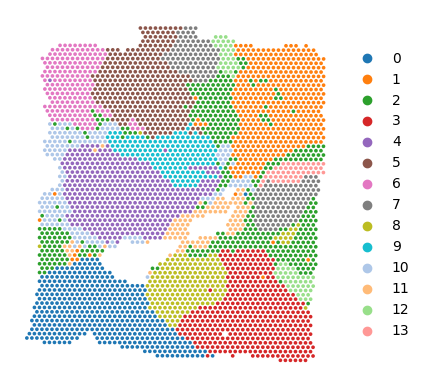

In [53]:
sc.pl.spatial(adata_2, img_key=None, color=['leiden_slat'], title=[''],
                show=True, frameon=False, palette = pathology_color,
                spot_size=spot_size)

In [5]:
adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])
sc.pp.neighbors(adata_com, use_rep = 'scSLAT')
sc.tl.umap(adata_com)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Anaconda\envs\scSLAT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


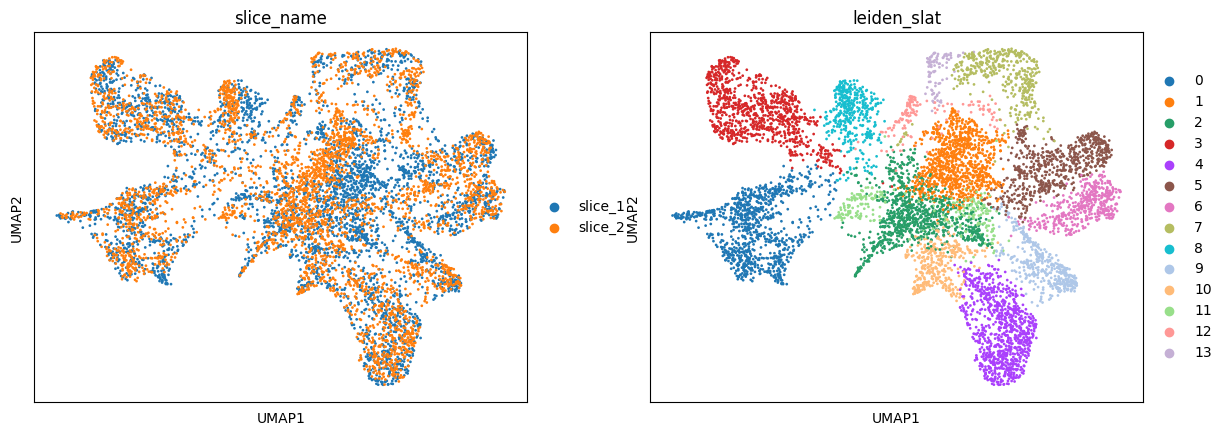

In [55]:
sc.pl.umap(adata_com, color=['slice_name', 'leiden_slat'])

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder

filtered_adata_1 = adata_1[adata_1.obs['anno_2'].isin(['CIS_1', 'CIS_2', 'CIS_3', 'CIS_4', 'CIS_5', 
                                                     'IDC_1', 'IDC_2', 'IDC_3', 'IDC_4', 'IDC_5', 'IDC_6', 'IDC_7']), :]

y_true = filtered_adata_1.obs['anno_2']
y_pred = filtered_adata_1.obs['leiden_slat']

label_encoder_true = LabelEncoder()
label_encoder_pred = LabelEncoder()

y_true_encoded = label_encoder_true.fit_transform(y_true)
y_pred_encoded = label_encoder_pred.fit_transform(y_pred)
ari = adjusted_rand_score(y_true_encoded, y_pred_encoded)
print(f"Adjusted Rand Index (ARI): {ari}")

nmi = normalized_mutual_info_score(y_true_encoded, y_pred_encoded)
print(f"Normalized Mutual Information (NMI): {nmi}")

Adjusted Rand Index (ARI): 0.7861754353534286
Normalized Mutual Information (NMI): 0.8235861251216877


In [ ]:
filtered_adata_2 = adata_2[adata_2.obs['anno_2'].isin(['CIS_1', 'CIS_2', 'CIS_3', 'CIS_4', 'CIS_5', 
                                                     'IDC_1', 'IDC_2', 'IDC_3', 'IDC_4', 'IDC_5', 'IDC_6', 'IDC_7']), :]

y_true = filtered_adata_2.obs['anno_2']
y_pred = filtered_adata_2.obs['leiden_slat']

label_encoder_true = LabelEncoder()
label_encoder_pred = LabelEncoder()
y_true_encoded = label_encoder_true.fit_transform(y_true)
y_pred_encoded = label_encoder_pred.fit_transform(y_pred)
ari = adjusted_rand_score(y_true_encoded, y_pred_encoded)
print(f"Adjusted Rand Index (ARI): {ari}")
nmi = normalized_mutual_info_score(y_true_encoded, y_pred_encoded)
print(f"Normalized Mutual Information (NMI): {nmi}")

Adjusted Rand Index (ARI): 0.7858047276006312
Normalized Mutual Information (NMI): 0.8211300183490278


In [ ]:
adata_com_filter_1 = sc.concat([filtered_adata_1, filtered_adata_2], label='slice_name', keys=['slice_1', 'slice_2'])
sc.pp.neighbors(adata_com_filter_1, use_rep = 'scSLAT')
sc.tl.umap(adata_com_filter_1)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


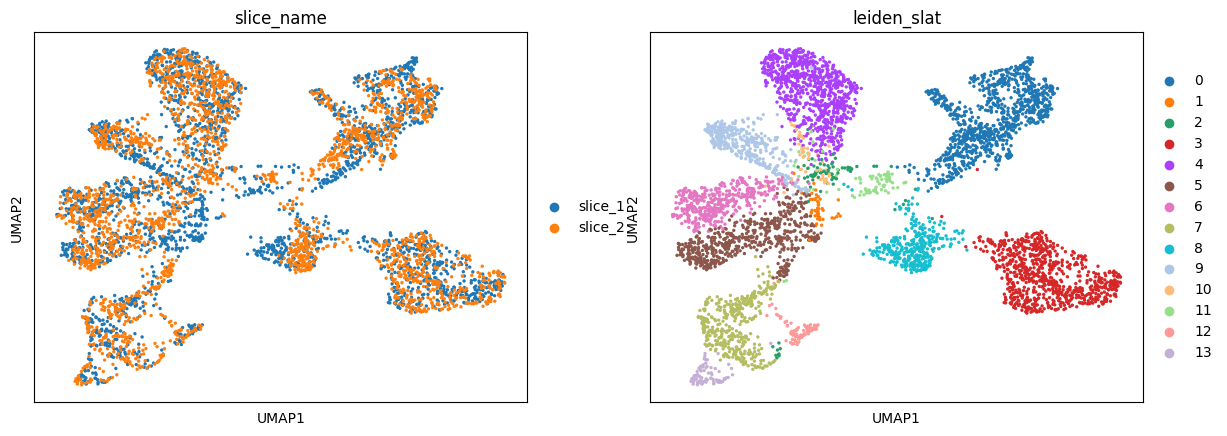

In [ ]:
sc.pl.umap(adata_com_filter_1, color=['slice_name', 'leiden_slat'])

In [ ]:
lisi_scores = compute_lisi_for_adata(adata_com_filter_1, obsm_key='scSLAT', obs_key_list=['anno_2', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.1905438399431447, 'iLISI': 1.7097801826260364}


In [ ]:
if "spatial" in filtered_adata_2.uns:
    existing_library_ids = list(filtered_adata_2.uns["spatial"].keys())
    print("Existing library_ids:", existing_library_ids)
else:
    print("No spatial data found in adata_2.uns.")

Existing library_ids: ['V1_Breast_Cancer_Block_A_Section_1']


In [ ]:
from PIL import Image
import numpy as np

image_path = "D:/ppppaper/data/BrCa/section2/spatial/tissue_hires_image.png"
image = np.array(Image.open(image_path))
image_path_2 = "D:/ppppaper/data/BrCa/section1/spatial/tissue_hires_image.png"
image_2 = np.array(Image.open(image_path_2))

In [61]:
library_id = 'V1_Breast_Cancer_Block_A_Section_2'
adata_1.uns["spatial"]['V1_Breast_Cancer_Block_A_Section_2']["images"]["hires"] = image
library_id_2 = 'V1_Breast_Cancer_Block_A_Section_1'
adata_2.uns["spatial"]['V1_Breast_Cancer_Block_A_Section_1']["images"]["hires"] = image_2

In [62]:
pathology_color_2 = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


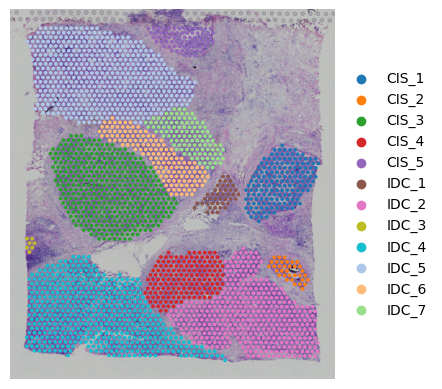

In [ ]:
sc.pl.spatial(filtered_adata_1, img_key="hires",
                library_id=library_id, color=['anno_2'], title=[''],
                show=True, frameon=False, palette = pathology_color_2,
                spot_size=spot_size)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


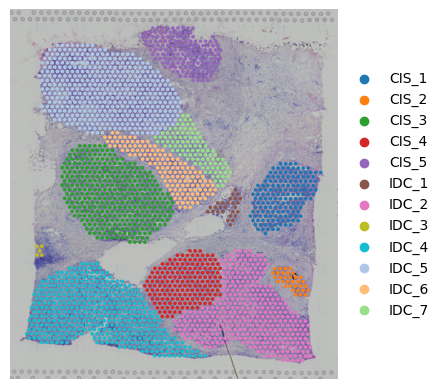

In [ ]:
sc.pl.spatial(filtered_adata_2, img_key="hires", 
                library_id=library_id_2, color=['anno_2'], title=[''],
                show=True, frameon=False, palette = pathology_color_2,
                spot_size=spot_size)

In [ ]:
filtered_adata_com = adata_com[adata_com.obs['anno_2'].isin(['CIS_1', 'CIS_2', 'CIS_3', 'CIS_4', 'CIS_5', 
                                                     'IDC_1', 'IDC_2', 'IDC_3', 'IDC_4', 'IDC_5', 'IDC_6', 'IDC_7']), :]
y_true = filtered_adata_com.obs['anno_2']
y_pred = filtered_adata_com.obs['leiden_slat']

label_encoder_true = LabelEncoder()
label_encoder_pred = LabelEncoder()
y_true_encoded = label_encoder_true.fit_transform(y_true)
y_pred_encoded = label_encoder_pred.fit_transform(y_pred)
ari = adjusted_rand_score(y_true_encoded, y_pred_encoded)
print(f"Adjusted Rand Index (ARI): {ari}")

nmi = normalized_mutual_info_score(y_true_encoded, y_pred_encoded)
print(f"Normalized Mutual Information (NMI): {nmi}")

Adjusted Rand Index (ARI): 0.7866997472282095
Normalized Mutual Information (NMI): 0.8148861739982918


In [15]:
adata_3 = sc.read_h5ad(r"D:\ppppaper\data\Result\BRCA_S2.h5ad")
adata_3.var_names_make_unique(join="++")
adata_3.obs = adata_3.obs.join(csv_data)
adata_3

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region_real', 'tumor_region', 'leiden', 'anno_2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Spatial_Net', 'spatial', 'tumor_region_colors', 'tumor_region_real_colors'
    obsm: 'scSLAT_bks', 'spatial'

In [16]:
adata_4 = sc.read_h5ad(r"D:\ppppaper\data\Result\BRCA_S1.h5ad")
adata_4.var_names_make_unique(join="++")
adata_4.obs = adata_4.obs.join(csv_data_2)
adata_4

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'leiden', 'anno_2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cell_type_colors', 'Spatial_Net', 'spatial'
    obsm: 'scSLAT_bks', 'spatial'

In [18]:
embd0 = adata_3.obs['leiden']
embd1 = adata_4.obs['leiden']

In [19]:
adata_com_2 = sc.concat([adata_3, adata_4], label='slice_name', keys=['slice_1', 'slice_2'])

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


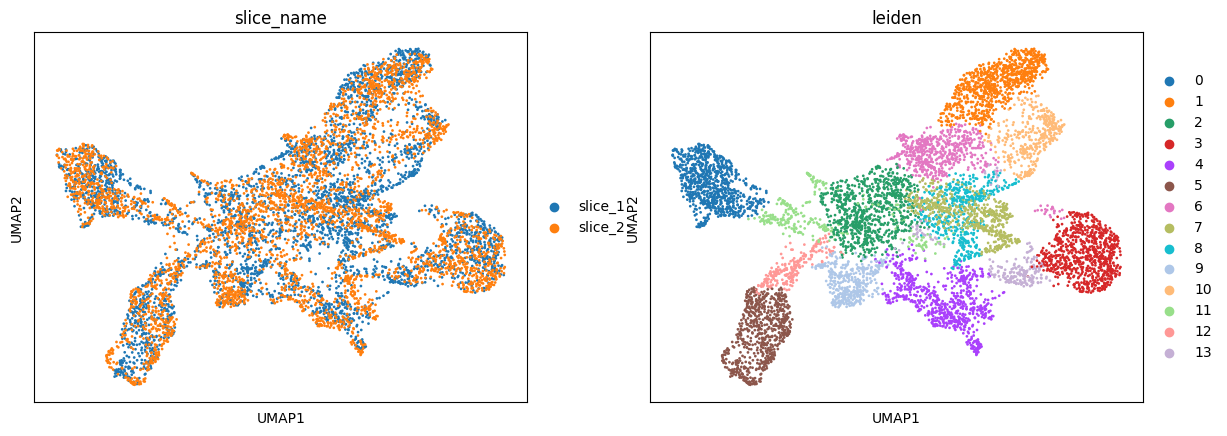

In [68]:
sc.pp.neighbors(adata_com_2, use_rep= 'scSLAT_bks')
sc.tl.umap(adata_com_2)
sc.pl.umap(adata_com_2, color= ['slice_name', 'leiden'])

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

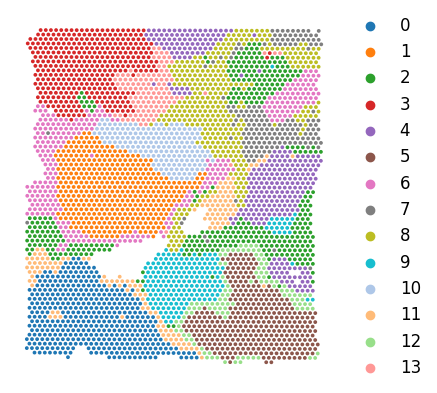

In [64]:
sc.pl.spatial(adata_3, img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [ ]:
filtered_adata_com_2 = adata_com_2[adata_com_2.obs['anno_2'].isin(['CIS_1', 'CIS_2', 'CIS_3', 'CIS_4', 'CIS_5', 
                                                     'IDC_1', 'IDC_2', 'IDC_3', 'IDC_4', 'IDC_5', 'IDC_6', 'IDC_7']), :]
y_true = filtered_adata_com_2.obs['anno_2']
y_pred = filtered_adata_com_2.obs['leiden']

label_encoder_true = LabelEncoder()
label_encoder_pred = LabelEncoder()
y_true_encoded = label_encoder_true.fit_transform(y_true)
y_pred_encoded = label_encoder_pred.fit_transform(y_pred)
ari = adjusted_rand_score(y_true_encoded, y_pred_encoded)
print(f"Adjusted Rand Index (ARI): {ari}")

nmi = normalized_mutual_info_score(y_true_encoded, y_pred_encoded)
print(f"Normalized Mutual Information (NMI): {nmi}")

Adjusted Rand Index (ARI): 0.7652470619629235
Normalized Mutual Information (NMI): 0.8006474305522622


In [ ]:
filtered_adata_3 = adata_3[adata_3.obs['anno_2'].isin(['CIS_1', 'CIS_2', 'CIS_3', 'CIS_4', 'CIS_5', 
                                                     'IDC_1', 'IDC_2', 'IDC_3', 'IDC_4', 'IDC_5', 'IDC_6', 'IDC_7']), :]

y_true = filtered_adata_3.obs['anno_2']
y_pred = filtered_adata_3.obs['leiden']

label_encoder_true = LabelEncoder()
label_encoder_pred = LabelEncoder()
y_true_encoded = label_encoder_true.fit_transform(y_true)
y_pred_encoded = label_encoder_pred.fit_transform(y_pred)
ari = adjusted_rand_score(y_true_encoded, y_pred_encoded)
print(f"Adjusted Rand Index (ARI): {ari}")
nmi = normalized_mutual_info_score(y_true_encoded, y_pred_encoded)
print(f"Normalized Mutual Information (NMI): {nmi}")

Adjusted Rand Index (ARI): 0.7352081950271951
Normalized Mutual Information (NMI): 0.7941452921783477


In [22]:
filtered_adata_4 = adata_4[adata_4.obs['anno_2'].isin(['CIS_1', 'CIS_2', 'CIS_3', 'CIS_4', 'CIS_5', 
                                                     'IDC_1', 'IDC_2', 'IDC_3', 'IDC_4', 'IDC_5', 'IDC_6', 'IDC_7']), :]

y_true = filtered_adata_4.obs['anno_2']
y_pred = filtered_adata_4.obs['leiden']

label_encoder_true = LabelEncoder()
label_encoder_pred = LabelEncoder()

y_true_encoded = label_encoder_true.fit_transform(y_true)
y_pred_encoded = label_encoder_pred.fit_transform(y_pred)
ari = adjusted_rand_score(y_true_encoded, y_pred_encoded)
print(f"Adjusted Rand Index (ARI): {ari}")

nmi = normalized_mutual_info_score(y_true_encoded, y_pred_encoded)
print(f"Normalized Mutual Information (NMI): {nmi}")

Adjusted Rand Index (ARI): 0.8011378821084576
Normalized Mutual Information (NMI): 0.8243067952269805


In [24]:
adata_com_filter_2 = sc.concat([filtered_adata_3, filtered_adata_4], label='slice_name', keys=['slice_1', 'slice_2'])
sc.pp.neighbors(adata_com_filter_2, use_rep = 'scSLAT_bks')
sc.tl.umap(adata_com_filter_2)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


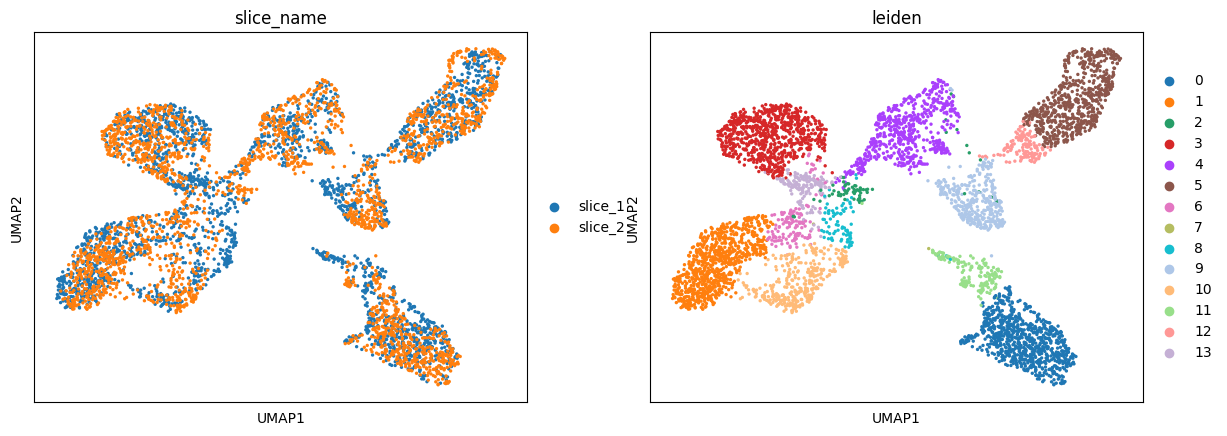

In [25]:
sc.pl.umap(adata_com_filter_2, color=['slice_name', 'leiden'])

In [26]:
lisi_scores = compute_lisi_for_adata(adata_com_filter_2, obsm_key='scSLAT_bks', obs_key_list=['anno_2', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.198761384219095, 'iLISI': 1.6697968642262646}


In [27]:
adata_5 = sc.read_h5ad('D:\ppppaper\data\BrCa\MY_BrCa_section2_BANKSY.h5ad')
adata_5.var_names_make_unique(join="++")
adata_5.obs = adata_5.obs.join(csv_data)
adata_5

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region_real', 'tumor_region', 'banksy_cluster', 'UMAP_1', 'UMAP_2', 'anno_2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'banksy_cluster_colors', 'spatial', 'tumor_region_colors', 'tumor_region_real_colors'
    obsm: 'banksy_pca', 'spatial'

In [28]:
adata_6 = sc.read_h5ad('D:\ppppaper\data\BrCa\MY_BrCa_section1_BANKSY.h5ad')
adata_6.var_names_make_unique(join="++")
adata_6.obs = adata_6.obs.join(csv_data_2)
adata_6

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'banksy_cluster', 'UMAP_1', 'UMAP_2', 'anno_2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cell_type_colors', 'banksy_cluster_colors', 'spatial'
    obsm: 'banksy_pca', 'spatial'

In [76]:
embd0 = adata_5.obsm['banksy_pca']
embd1 = adata_6.obsm['banksy_pca']

In [29]:
adata_com_3 = sc.concat([adata_5, adata_6], label='slice_name', keys=['slice_1', 'slice_2'])

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


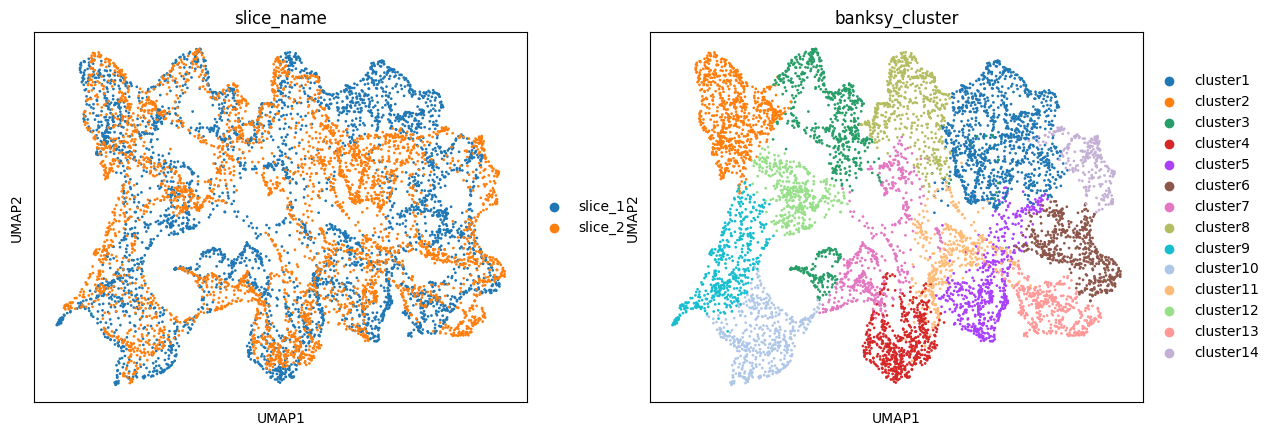

In [78]:
sc.pp.neighbors(adata_com_3, use_rep= 'banksy_pca')
sc.tl.umap(adata_com_3)
sc.pl.umap(adata_com_3, color= ['slice_name', 'banksy_cluster'])

In [ ]:
filtered_adata_5 = adata_5[adata_5.obs['anno_2'].isin(['CIS_1', 'CIS_2', 'CIS_3', 'CIS_4', 'CIS_5', 
                                                     'IDC_1', 'IDC_2', 'IDC_3', 'IDC_4', 'IDC_5', 'IDC_6', 'IDC_7']), :]

y_true = filtered_adata_5.obs['anno_2']
y_pred = filtered_adata_5.obs['banksy_cluster']

label_encoder_true = LabelEncoder()
label_encoder_pred = LabelEncoder()
y_true_encoded = label_encoder_true.fit_transform(y_true)
y_pred_encoded = label_encoder_pred.fit_transform(y_pred)
ari = adjusted_rand_score(y_true_encoded, y_pred_encoded)
print(f"Adjusted Rand Index (ARI): {ari}")
nmi = normalized_mutual_info_score(y_true_encoded, y_pred_encoded)
print(f"Normalized Mutual Information (NMI): {nmi}")

Adjusted Rand Index (ARI): 0.6300015678266762
Normalized Mutual Information (NMI): 0.7944359388480383


In [ ]:
filtered_adata_6 = adata_6[adata_6.obs['anno_2'].isin(['CIS_1', 'CIS_2', 'CIS_3', 'CIS_4', 'CIS_5', 
                                                     'IDC_1', 'IDC_2', 'IDC_3', 'IDC_4', 'IDC_5', 'IDC_6', 'IDC_7']), :]

y_true = filtered_adata_6.obs['anno_2']
y_pred = filtered_adata_6.obs['banksy_cluster']
label_encoder_true = LabelEncoder()
label_encoder_pred = LabelEncoder()
y_true_encoded = label_encoder_true.fit_transform(y_true)
y_pred_encoded = label_encoder_pred.fit_transform(y_pred)
ari = adjusted_rand_score(y_true_encoded, y_pred_encoded)
print(f"Adjusted Rand Index (ARI): {ari}")

nmi = normalized_mutual_info_score(y_true_encoded, y_pred_encoded)
print(f"Normalized Mutual Information (NMI): {nmi}")

Adjusted Rand Index (ARI): 0.6946810662000216
Normalized Mutual Information (NMI): 0.8194475769242509


In [40]:
adata_com_filter_3 = sc.concat([filtered_adata_5, filtered_adata_6], label='slice_name', keys=['slice_1', 'slice_2'])
sc.pp.neighbors(adata_com_filter_3, use_rep = 'banksy_pca')
sc.tl.umap(adata_com_filter_3)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


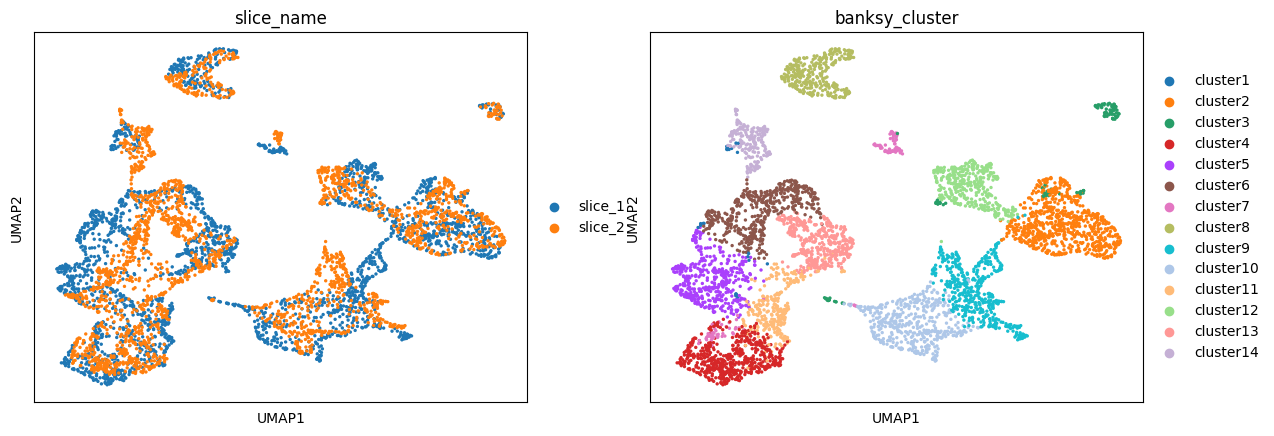

In [41]:
sc.pl.umap(adata_com_filter_3, color=['slice_name', 'banksy_cluster'])

In [43]:
lisi_scores = compute_lisi_for_adata(adata_com_filter_3, obsm_key='banksy_pca', obs_key_list=['anno_2', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.1009808921772546, 'iLISI': 1.4219486129822543}
